In [282]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [283]:
# Simulation parameters
n_stocks = 100
n_quarters = 20

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 1, len(df))
df["ptb_change"] = np.random.normal(0, 1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = 0.2
#hom_slope_2 = 0.65

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 1) for stock in stocks}
time_effects = {q: np.random.normal(0, 1) for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 4 - 3*np.random.rand() for stock in stocks}
#time_slopes = {q: 4 - 3*np.random.rand() for q in quarters}

df["stock_slope"] = df["stock_id"].map(stock_slopes)
df["stock_bias"] = df["stock_id"].map(stock_effects)
df["time_bias"] = df["quarter"].map(time_effects)

# Simulate returns using all components
df["return"] = (
    df["stock_bias"]
    + df["time_bias"]
    + hom_slope * df["ptb_change"]
    + df["stock_slope"] * df["div_yield_change"]
    #+ np.random.normal(0, 0.05, len(df))  # Optional noise
)

df.head(25)


,stock_id,quarter,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return
0,Stock_0,0,0.496714,-0.675178,2.800051,-0.863494,-1.500222,-1.107926
1,Stock_0,1,-0.138264,-0.144519,2.800051,-0.863494,-0.778837,-2.058381
2,Stock_0,2,0.647689,-0.792420,2.800051,-0.863494,1.351073,2.142656
3,Stock_0,3,1.523030,-0.307962,2.800051,-0.863494,0.886191,4.225666
4,Stock_0,4,-0.234153,-1.893615,2.800051,-0.863494,-0.062640,-1.960497
5,Stock_0,5,-0.234137,0.213294,2.800051,-0.863494,0.243123,-1.233307
6,Stock_0,6,1.579213,0.001205,2.800051,-0.863494,-0.294243,3.264381
7,Stock_0,7,0.767435,-0.817089,2.800051,-0.863494,1.356583,2.478528
8,Stock_0,8,-0.469474,0.659246,2.800051,-0.863494,-0.200353,-2.246549
9,Stock_0,9,0.542560,0.937570,2.800051,-0.863494,0.231842,1.075058


In [284]:
df["stock_slope"].mean()

2.4852810725816963

In [332]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=False,
    time_effects=False
)
results = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.6915
Estimator:                   PanelOLS   R-squared (Between):              0.3125
No. Observations:                2000   R-squared (Within):               0.7590
Date:                Wed, Apr 16 2025   R-squared (Overall):              0.6915
Time:                        23:30:43   Log-likelihood                   -3847.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2239.4
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1998)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             398.98
                            

In [333]:
# Predictions
df["predicted_return"] = results.predict().fitted_values
df_reset = df.reset_index()

df.head(25)

index  div_yield_change  ptb_change  stock_slope  \
stock_id quarter                                                     
Stock_0  0            0          0.496714   -0.675178     2.800051   
         1            1         -0.138264   -0.144519     2.800051   
         2            2          0.647689   -0.792420     2.800051   
         3            3          1.523030   -0.307962     2.800051   
         4            4         -0.234153   -1.893615     2.800051   
         5            5         -0.234137    0.213294     2.800051   
         6            6          1.579213    0.001205     2.800051   
         7            7          0.767435   -0.817089     2.800051   
         8            8         -0.469474    0.659246     2.800051   
         9            9          0.542560    0.937570     2.800051   
         10          10         -0.463418   -1.607560     2.800051   
         11          11         -0.465730   -0.762725     2.800051   
         12          12          0.241962   -0.769142     2.800051   
         13          13         -1.913280   -0.939903     2.800051   
         14          14         -1.724918    0.829475     2.800051   
         15          15         -0.562288   -0.193826     2.800051   
         16          16         -1.012831   -0.264515     2.800051   
         17          17          0.314247   -2.003862     2.800051   
         18          18         -0.908024    0.635418     2.800051   
         19          19         -1.412304   -1.239258     2.800051   
Stock_1  0           20          1.465649    0.059933     3.827824   
         1           21         -0.225776    0.277377     3.827824   
         2           22          0.067528    1.360659     3.827824   
         3           23         -1.424748   -1.308820     3.827824   
         4           24         -0.544383   -3.019512     3.827824   

                  stock_bias  time_bias    return  predicted_return  \
stock_id quarter                                                      
Stock_0  0         -0.863494  -1.500222 -1.107926          1.089618   
         1         -0.863494  -0.778837 -2.058381         -0.378533   
         2         -0.863494   1.351073  2.142656          1.440711   
         3         -0.863494   0.886191  4.225666          3.739767   
         4         -0.863494  -0.062640 -1.960497         -1.014159   
         5         -0.863494   0.243123 -1.233307         -0.537367   
         6         -0.863494  -0.294243  3.264381          3.950252   
         7         -0.863494   1.356583  2.478528          1.734642   
         8         -0.863494  -0.200353 -2.246549         -1.025091   
         9         -0.863494   0.231842  1.075058          1.569222   
         10        -0.863494   1.146030 -1.336569         -1.522874   
         11        -0.863494  -0.777371 -3.097477         -1.337488   
         12        -0.863494   1.558789  1.218974          0.431163   
         13        -0.863494  -1.530461 -7.939218         -4.998240   
         14        -0.863494   1.629642 -3.897814         -4.126728   
         15        -0.863494  -0.372676 -2.849368         -1.450271   
         16        -0.863494  -0.242699 -3.995074         -2.593181   
         17        -0.863494  -1.890010 -2.274368          0.332572   
         18        -0.863494  -0.454795 -3.733718         -2.127397   
         19        -0.863494  -1.039807 -6.105674         -3.812919   
Stock_1  0         -0.031203  -1.500222  4.090807          3.679490   
         1         -0.031203  -0.778837 -1.618797         -0.501954   
         2         -0.031203   1.351073  1.850487          0.476793   
         3         -0.031203   0.886191 -4.860462         -3.859786   
         4         -0.031203  -0.062640 -2.781547         -2.044882   

                  embed_dim_0  embed_dim_1  ...  embed_dim_3  embed_dim_4  \
stock_id quarter                            ...                             
Stock_0  0          -1.428266    -0.477481  ...    -0.1

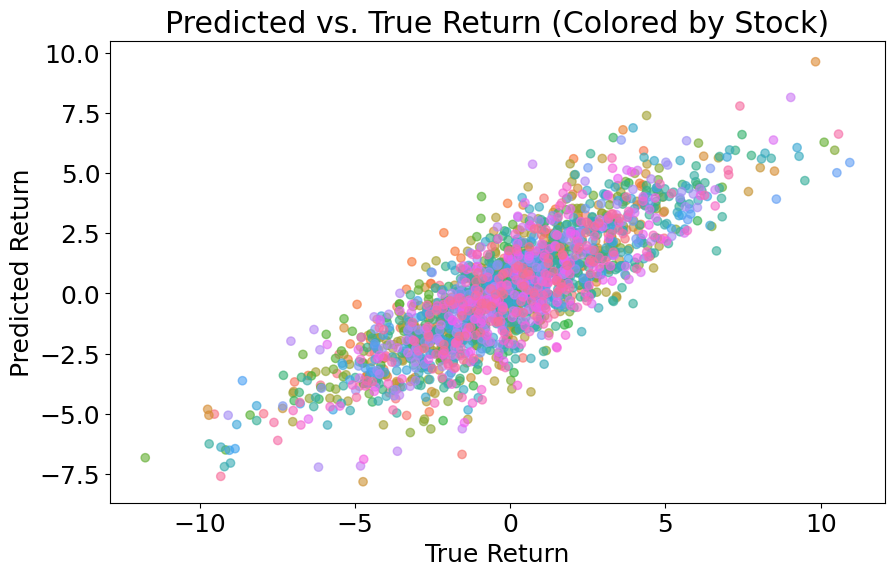

In [287]:
df = df.reset_index()

import seaborn as sns
# Create a color palette for stocks
unique_stocks = df["stock_id"].unique()
palette = sns.color_palette("husl", len(unique_stocks))  # bright, distinct colors
stock_color_map = dict(zip(unique_stocks, palette))

# Map stock_id to colors
colors = df["stock_id"].map(stock_color_map)

# Plot with colored points
plt.figure(figsize=(10, 6))
plt.scatter(df["return"], df["predicted_return"], c=colors, alpha=0.6)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs. True Return (Colored by Stock)")
plt.show()

In [288]:
from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["predicted_return"])}')

Mean-squared Error: 2.7452113488533922
Correlation: 0.6915055155781259


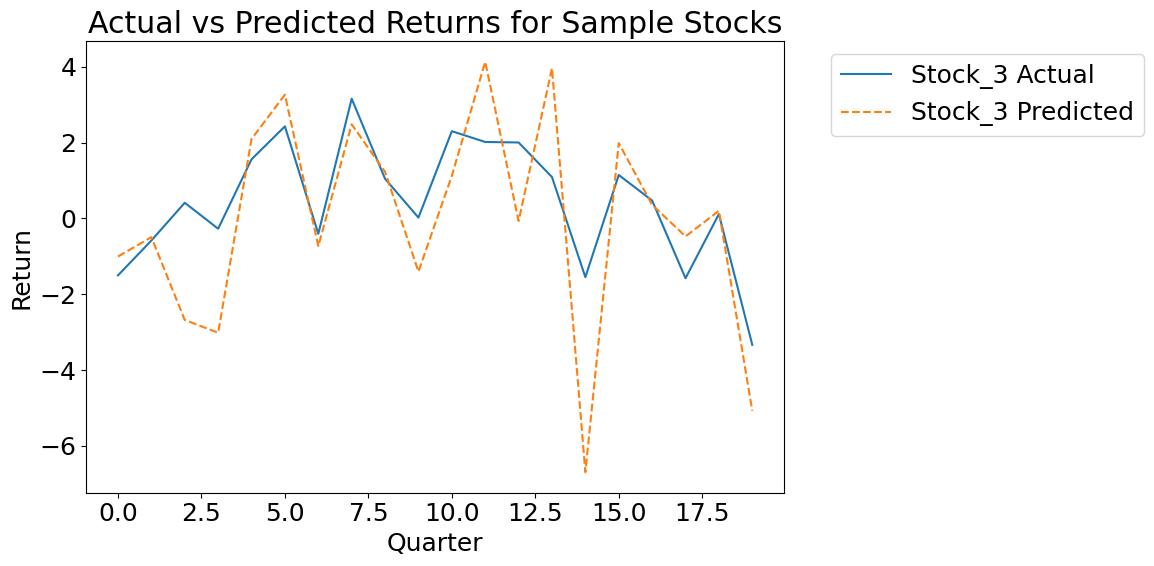

In [336]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[3:4]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [291]:
# Hyperparameters
num_stocks = 100
embedding_dim = 12
epochs = 500
lr = 0.01

# Example: use average return per stock as the target
avg_return_per_stock = df.groupby("stock_id")["stock_slope"].mean()
true_targets = torch.tensor(avg_return_per_stock.values, dtype=torch.float32).unsqueeze(1)

# Dataset (each sample is one stock)
stock_ids = torch.arange(num_stocks)

# Model
class StockEmbedder(nn.Module):
    def __init__(self, num_stocks, embedding_dim):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        self.predictor = nn.Linear(embedding_dim, 1)  # Dummy prediction head
    
    def forward(self, stock_ids):
        stock_vecs = self.stock_embedding(stock_ids)         # [N, 4]
        preds = self.predictor(stock_vecs)  # dummy prediction task
        return stock_vecs, preds

# Instantiate
embedder = StockEmbedder(num_stocks, embedding_dim)
optimizer = optim.Adam(embedder.parameters(), lr=lr)
mse = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    embedder.train()
    optimizer.zero_grad()

    stock_vecs, preds = embedder(stock_ids)
    
    # Dummy regression loss
    prediction_loss = mse(preds, true_targets)

    # Total loss
    loss = prediction_loss
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")

stock_embeddings = embedder.stock_embedding.weight.detach().numpy()
print(stock_embeddings.shape)

Epoch 50/500, Total Loss: 0.5278
Epoch 100/500, Total Loss: 0.0030
Epoch 150/500, Total Loss: 0.0000
Epoch 200/500, Total Loss: 0.0000
Epoch 250/500, Total Loss: 0.0000
Epoch 300/500, Total Loss: 0.0000
Epoch 350/500, Total Loss: 0.0000
Epoch 400/500, Total Loss: 0.0000
Epoch 450/500, Total Loss: 0.0000
Epoch 500/500, Total Loss: 0.0000
(100, 12)


In [249]:
'''# ---- Visualize embeddings using t-SNE ----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]
    industry_colors = stock_to_industry.numpy()

    # Reduce to 2D using t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    stock_2d = tsne.fit_transform(stock_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap='tab10', s=50)
    plt.title("t-SNE projection of Stock Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()'''

'# ---- Visualize embeddings using t-SNE ----\nembedder.eval()\nwith torch.no_grad():\n    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]\n    industry_colors = stock_to_industry.numpy()\n\n    # Reduce to 2D using t-SNE for visualization\n    tsne = TSNE(n_components=2, random_state=42)\n    stock_2d = tsne.fit_transform(stock_embeddings)\n\n    # Plot\n    plt.figure(figsize=(10, 6))\n    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap=\'tab10\', s=50)\n    plt.title("t-SNE projection of Stock Embeddings")\n    plt.xlabel("Dim 1")\n    plt.ylabel("Dim 2")\n    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")\n    plt.gca().add_artist(legend1)\n    plt.grid(True)\n    plt.show()'

In [292]:
df = df.reset_index()

# ----- Get stock embeddings from the trained model -----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, 4]

# Create a DataFrame mapping stock name to its embedding
embedding_df = pd.DataFrame(stock_embeddings, columns=[f"embed_dim_{i}" for i in range(embedding_dim)])
embedding_df["stock_id"] = [f"Stock_{i}" for i in range(n_stocks)]

# ----- Merge embeddings into the panel -----
df = df.merge(embedding_df, on="stock_id", how="left")

df.head()

,index,stock_id,quarter,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return,predicted_return,...,embed_dim_2,embed_dim_3,embed_dim_4,embed_dim_5,embed_dim_6,embed_dim_7,embed_dim_8,embed_dim_9,embed_dim_10,embed_dim_11
0,0,Stock_0,0,0.496714,-0.675178,2.800051,-0.863494,-1.500222,-1.107926,1.089618,...,1.16704,-0.125675,1.214018,1.475968,1.356913,-0.337167,-1.65075,-0.618976,2.047484,-1.778603
1,1,Stock_0,1,-0.138264,-0.144519,2.800051,-0.863494,-0.778837,-2.058381,-0.378533,...,1.16704,-0.125675,1.214018,1.475968,1.356913,-0.337167,-1.65075,-0.618976,2.047484,-1.778603
2,2,Stock_0,2,0.647689,-0.792420,2.800051,-0.863494,1.351073,2.142656,1.440711,...,1.16704,-0.125675,1.214018,1.475968,1.356913,-0.337167,-1.65075,-0.618976,2.047484,-1.778603
3,3,Stock_0,3,1.523030,-0.307962,2.800051,-0.863494,0.886191,4.225666,3.739767,...,1.16704,-0.125675,1.214018,1.475968,1.356913,-0.337167,-1.65075,-0.618976,2.047484,-1.778603
4,4,Stock_0,4,-0.234153,-1.893615,2.800051,-0.863494,-0.062640,-1.960497,-1.014159,...,1.16704,-0.125675,1.214018,1.475968,1.356913,-0.337167,-1.65075,-0.618976,2.047484,-1.778603


In [399]:
# Use stock_id and quarter as context
#context_df = df[["embed_dim_0", "embed_dim_1", "embed_dim_2", "embed_dim_3", "quarter"]].copy()
#context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["div_yield_change", "ptb_change"]].values
Y = df["return"].values.reshape(-1, 1)
C = df[["stock_slope", "stock_bias", "time_bias"]].values  # context = (stock_id, quarter)

In [400]:
# -------------------------------
# 3. Split and normalize
# -------------------------------

C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

In [372]:
model = ContextualizedRegressor(n_bootstraps=20)
model.fit(C, X, Y,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck.

In [401]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C)
Y_pred = model.predict(C, X)
df["predicted_return_context"] = Y_pred

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(Y, Y_pred)}')
print(f'Correlation: {r2_score(Y, Y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Mean-squared Error: 0.015627251582718833
Correlation: 0.9982438798666794


In [402]:
contextualized_coeffs, contextualized_offsets

(array([[[2.72378966, 0.19304914]],
 
        [[2.72877053, 0.18600654]],
 
        [[2.76333381, 0.17595597]],
 
        ...,
 
        [[1.42150935, 0.195645  ]],
 
        [[1.16501611, 0.20211211]],
 
        [[1.23887754, 0.19943654]]]),
 array([[-2.32155199],
        [-1.61435009],
        [ 0.49920399],
        ...,
        [-1.61457465],
        [-0.34389232],
        [-0.89538333]]))

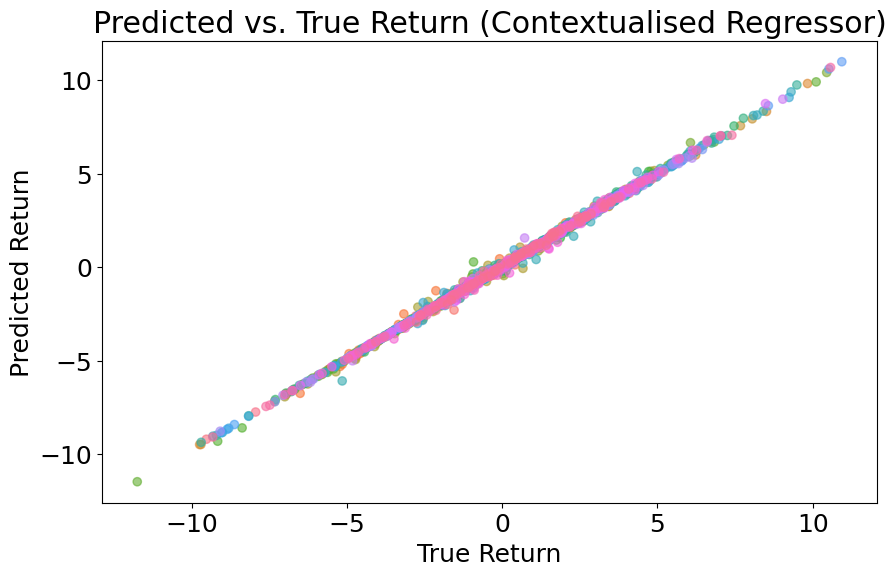

In [403]:
# Plot with colored points
plt.figure(figsize=(10, 6))
plt.scatter(df["return"], df["predicted_return_context"], c=colors, alpha=0.6)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Predicted vs. True Return (Contextualised Regressor)")
plt.show()

In [404]:
%%capture
coefs, offsets = model.predict_params(C, individual_preds=False)
coefs.shape # (n_samples, n_outputs, n_predictors)
offsets.shape  # (n_samples, n_outputs)

# Contextualized linear regression coefficients are shape:
# (n_samples, n_outputs, n_predictors)
# Let's squeeze out the n_outputs axis since we only have 1 output in this example.
coefs = np.squeeze(coefs)

# Any embedding method could be used; here we will use UMAP.
'''from umap import UMAP
um = UMAP(n_neighbors=5)
model_reps = um.fit_transform(coefs)'''

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
model_reps = pca.fit_transform(coefs)

C = pd.DataFrame(C, columns=["stock_slope", "stock_bias", "time_bias"])
X = pd.DataFrame(X, columns=["div_yield_change", "ptb_change"])

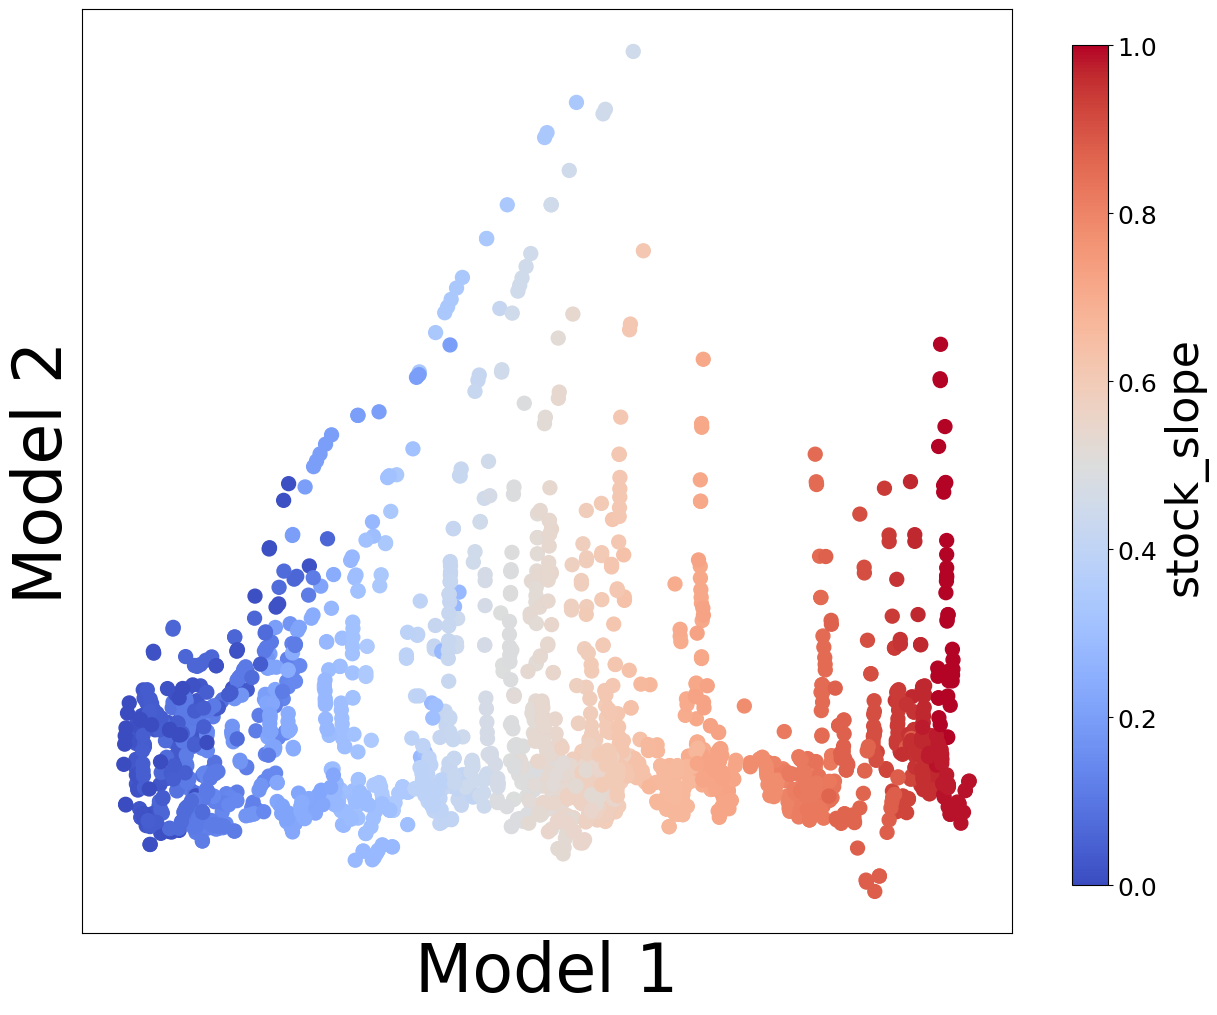

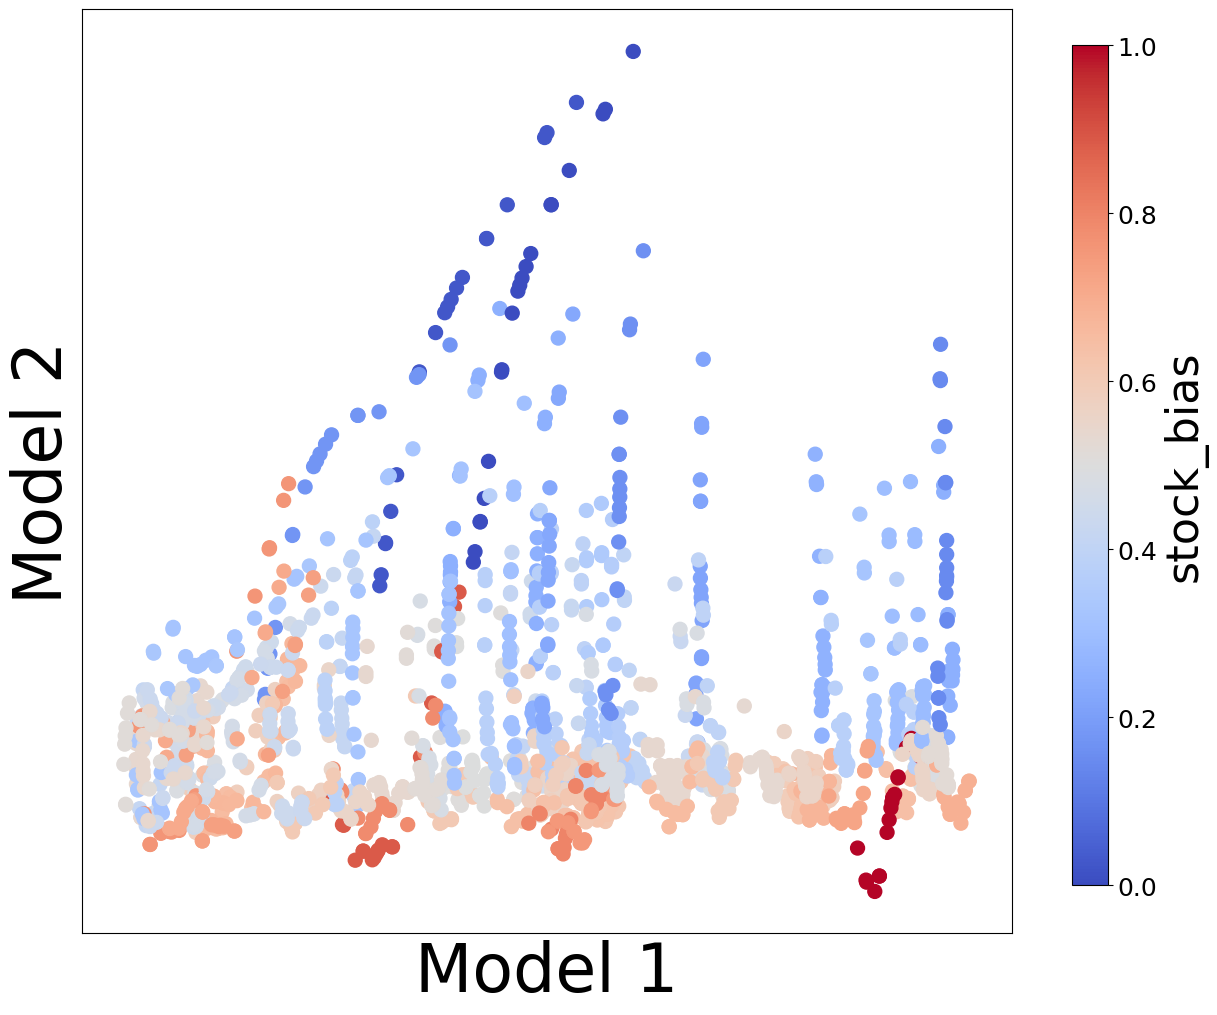

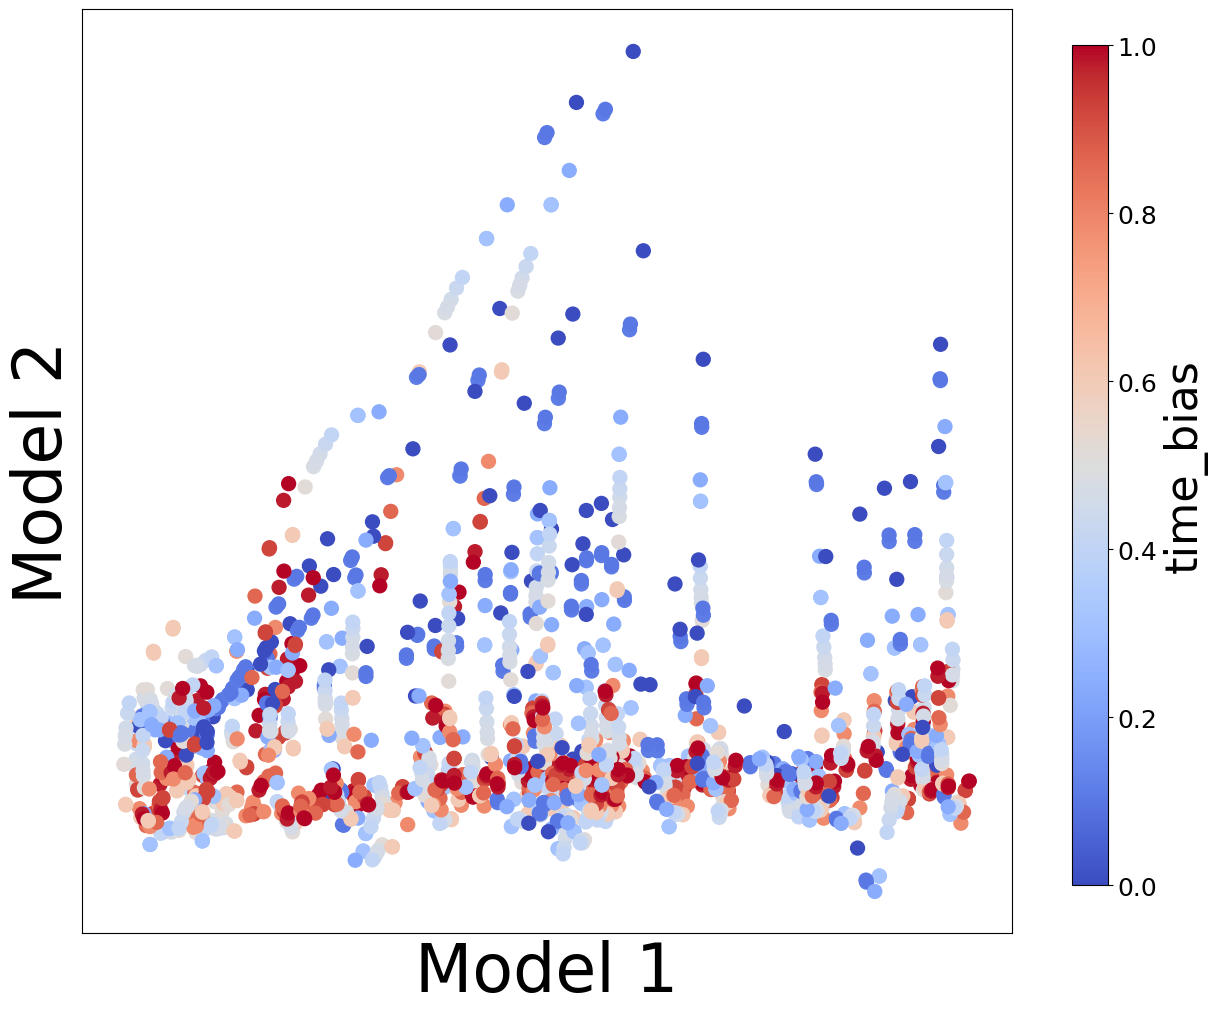

In [405]:
# A simple helper function is provided in the analysis toolkit for plotting embeddings.
from contextualized.analysis.embeddings import plot_embedding_for_all_covars
plot_embedding_for_all_covars(model_reps, C, xlabel='Model 1', ylabel='Model 2')

In [406]:
from contextualized.analysis.effects import (
    plot_homogeneous_context_effects,
    plot_homogeneous_predictor_effects,
    plot_heterogeneous_predictor_effects,
)

from contextualized.analysis.pvals import (
    calc_homogeneous_context_effects_pvals,
    calc_homogeneous_predictor_effects_pvals,
    calc_heterogeneous_predictor_effects_pvals
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


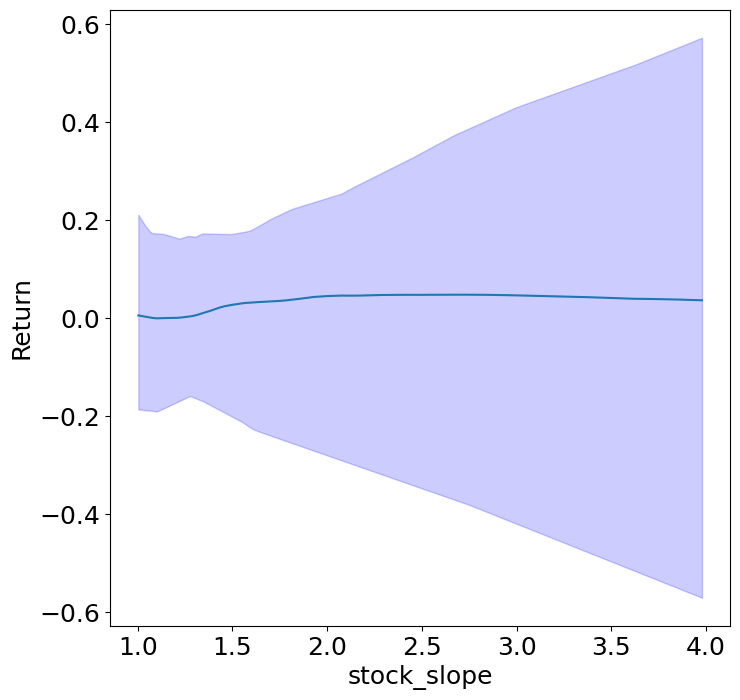

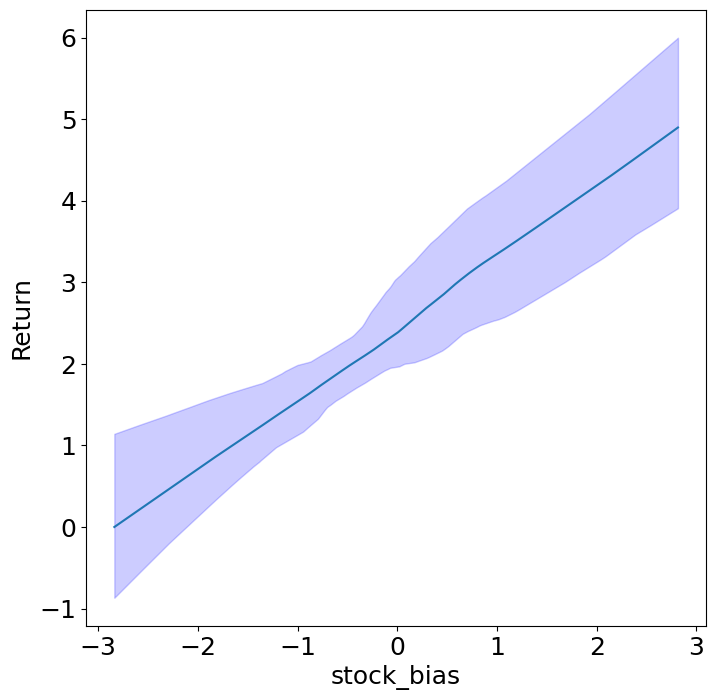

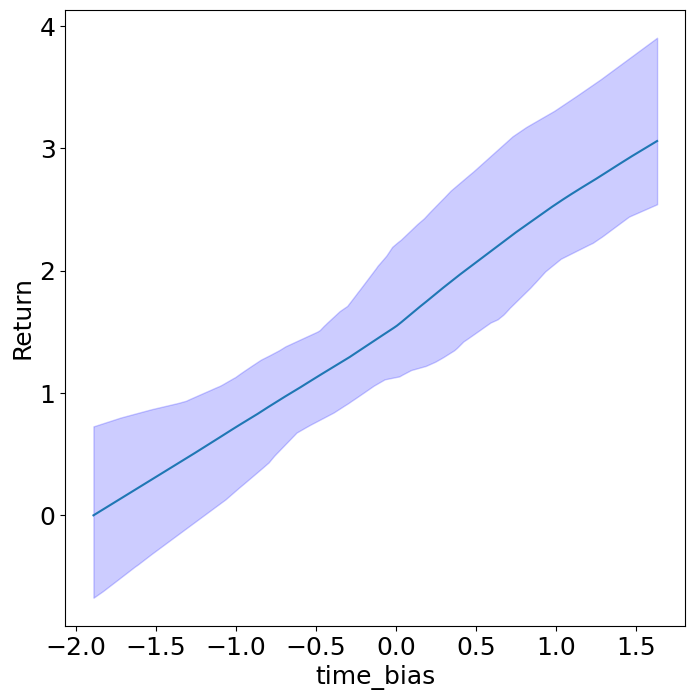

In [407]:
plot_homogeneous_context_effects(
    model, C, classification=False,
    ylabel="Return", verbose=False)

In [408]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_context_pvals = calc_homogeneous_context_effects_pvals(model, C)
context_pvals = pd.DataFrame(np.array([
   [C.columns[i], pval[0]] for i, pval in enumerate(homogeneous_context_pvals)
]), columns=["Context Variable", "p-value"])

In [409]:
context_pvals
# Notice that the p-values are calculated from bootstrap resampling,
# so they are limited by the number of bootstraps used.
# Caution: using more bootstraps could artificially inflate confidence.

,Context Variable,p-value
0,stock_slope,0.3333333333333333
1,stock_bias,0.047619047619047616
2,time_bias,0.047619047619047616


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


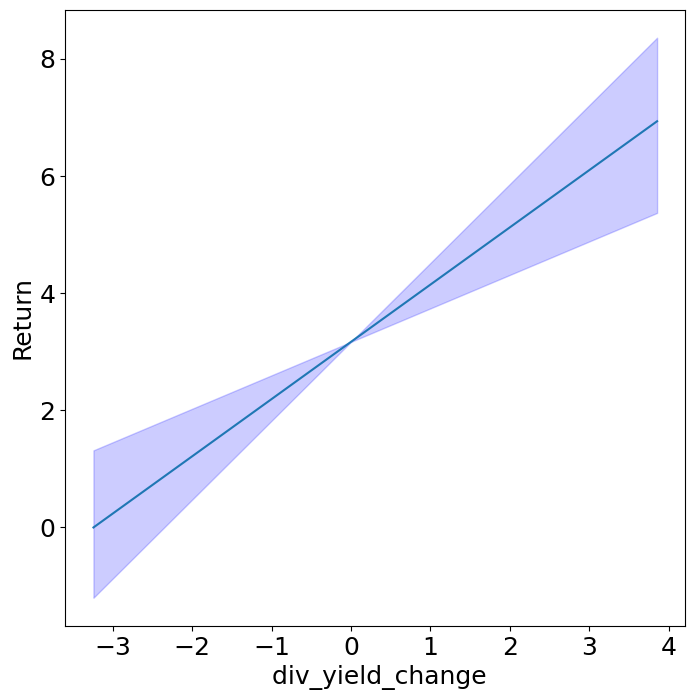

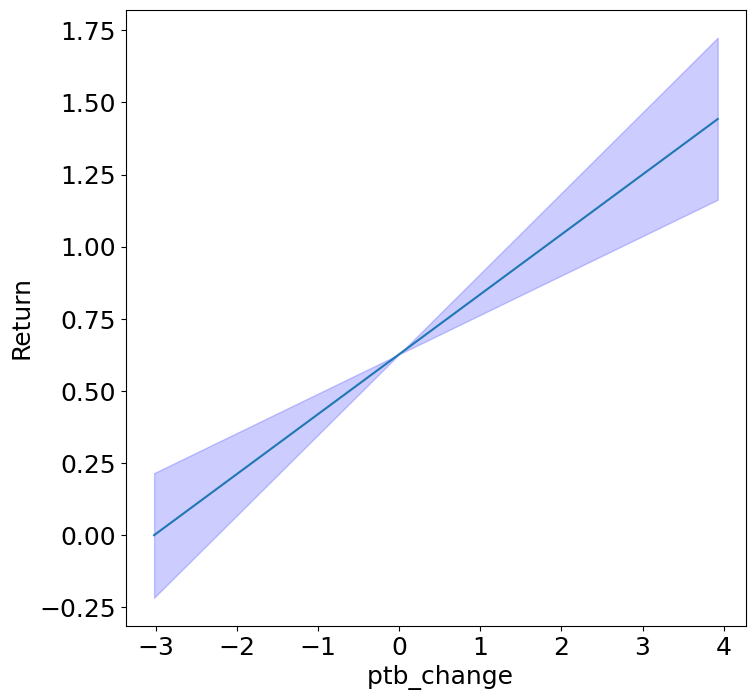

In [410]:
plot_homogeneous_predictor_effects(
    model, C, X,
    ylabel="Return",
    classification=False)

In [411]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
homogeneous_predictor_pvals = calc_homogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [X.columns[i], pval[0]] for i, pval in enumerate(homogeneous_predictor_pvals)
]), columns=["Predictor", "p-value"])

In [412]:
predictor_pvals

,Predictor,p-value
0,div_yield_change,0.047619047619047616
1,ptb_change,0.09523809523809523


Generating datapoints for visualization by assuming the encoder is
            an additive model and thus doesn't require sampling on a manifold.
            If the encoder has interactions, please supply C_vis so that we
            can visualize these effects on the correct data manifold.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


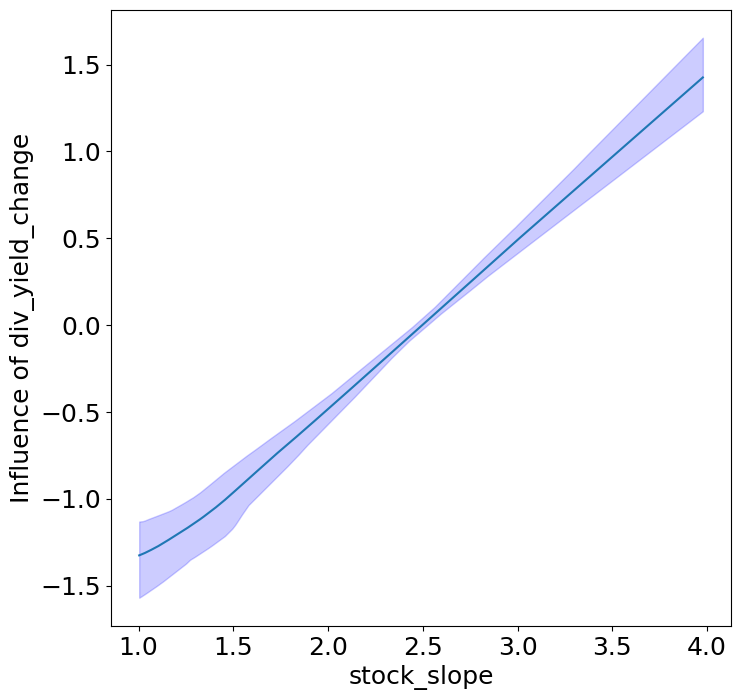

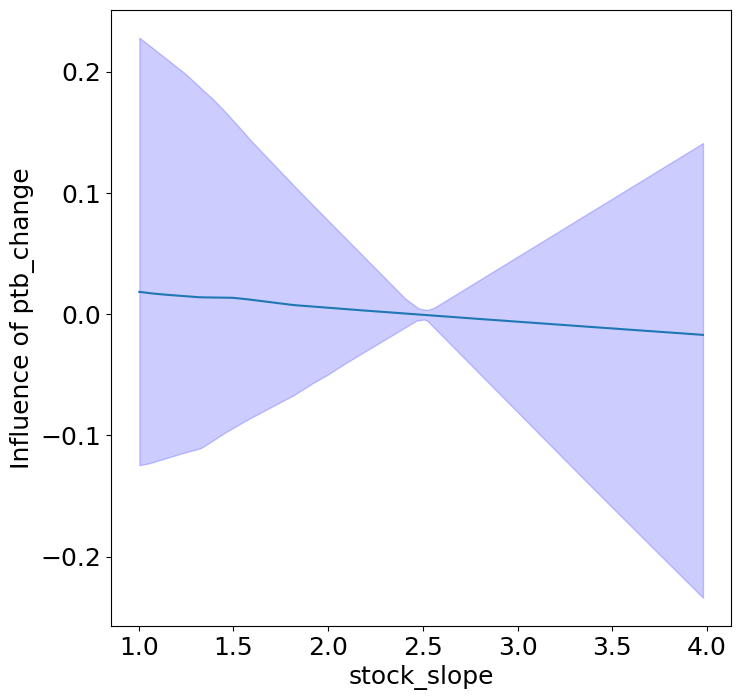

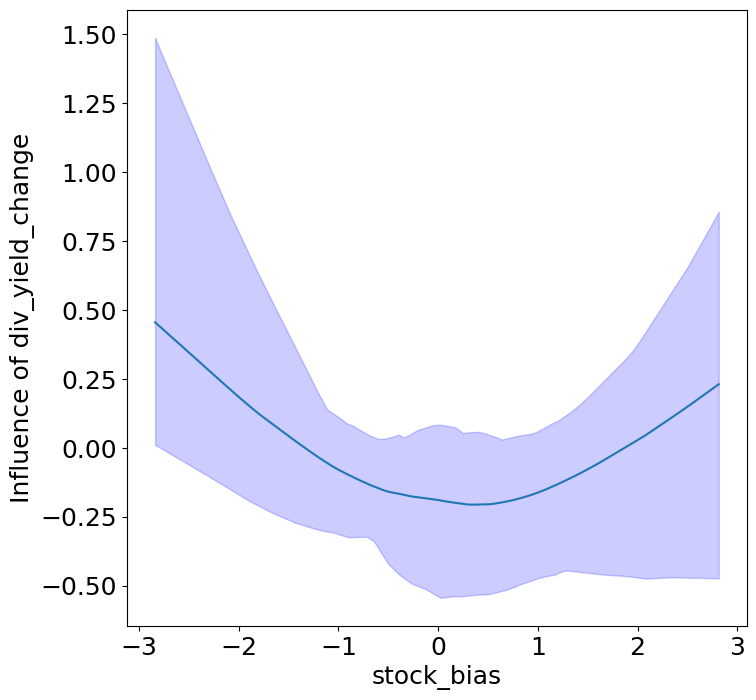

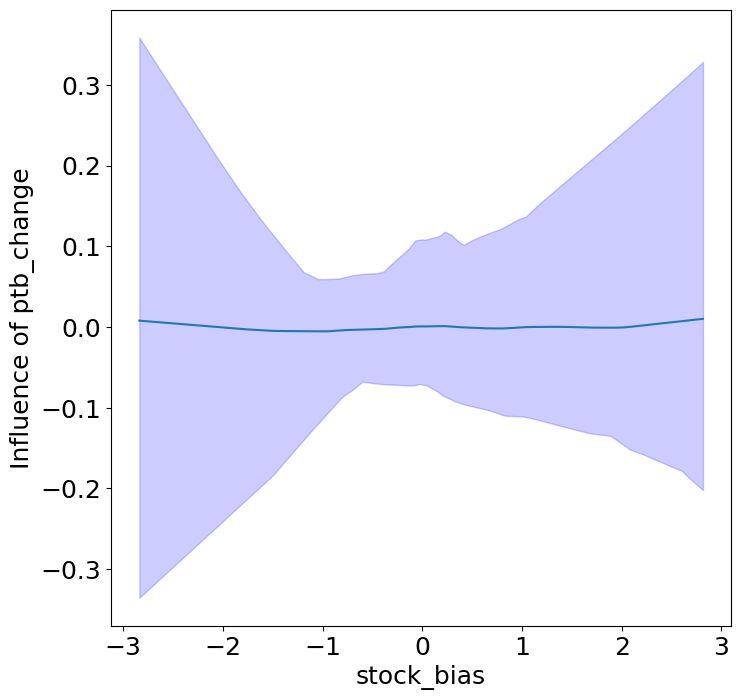

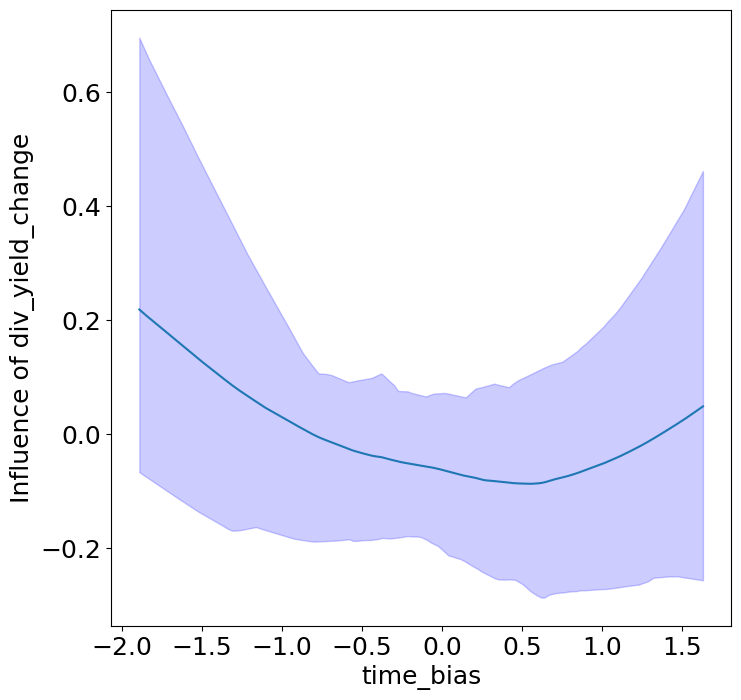

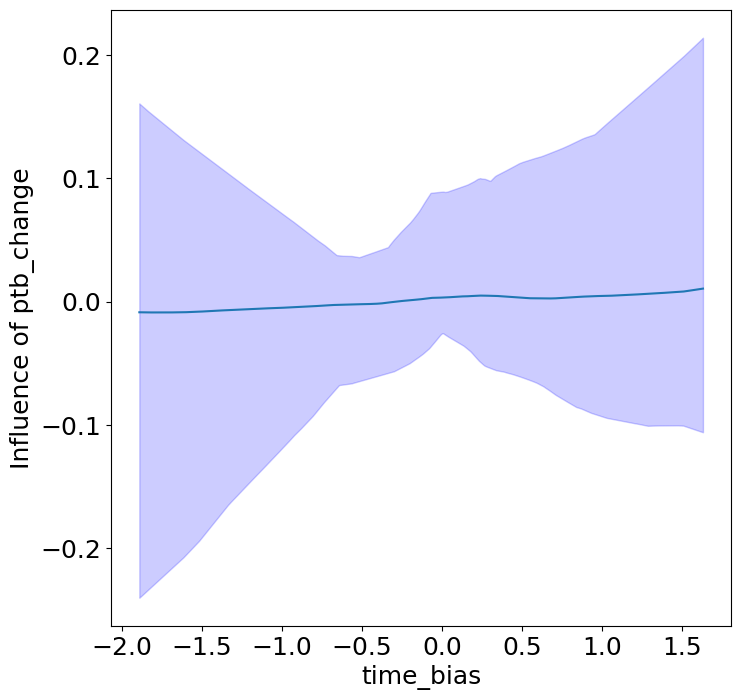

In [413]:
plot_heterogeneous_predictor_effects(model, C, X, min_effect_size=0.1,
                  ylabel="Influence of")
# Since there are a combinatorial number of heterogeneous predictor effects,
# min_effect_size is a useful parameter to restrict the plotting to
# only the strongest effects.

In [414]:
%%capture
# We can quantify the uncertainty visualized in the bootstrap confidence intervals
# by measuring p-values of the consistency of the estimated sign of each effect.
# This is a combinatorial: context x predictor
heterogeneous_predictor_pvals = calc_heterogeneous_predictor_effects_pvals(model, C)
predictor_pvals = pd.DataFrame(np.array([
   [C.columns[i // len(X.columns)], X.columns[i % len(X.columns)], pval] for i, pval in enumerate(heterogeneous_predictor_pvals.flatten())
]), columns=["Context", "Predictor", "p-value"])

In [415]:
predictor_pvals

,Context,Predictor,p-value
0,stock_slope,div_yield_change,0.047619047619047616
1,stock_slope,ptb_change,0.38095238095238093
2,stock_bias,div_yield_change,0.3333333333333333
3,stock_bias,ptb_change,0.5714285714285714
4,time_bias,div_yield_change,0.2857142857142857
5,time_bias,ptb_change,0.5714285714285714
